### Importando Bibliotecas a serem utilizadas

In [198]:
import yfinance as yf
import pandas as pd
from bcb import sgs, currency
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose #decomposição
from statsmodels.tsa.seasonal import STL #decomposição
from statsmodels.tsa.stattools import adfuller #teste Estatistico de Fuller (PValue)
from statsmodels.tsa.stattools import acf, pacf #Auto Correlação (ACF) Auto correlação Parcial (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics as st 

### Criando as tabelas

Utilizando a biblioteca Python 'yfinance' que possui os dados diários através do link(https://finance.yahoo.com/quote/%5EBVSP/history/)

O Yahoo Finance utiliza 5 colunas relativas a preço do ativos:

- Open -> Preço de abertura do dia do ativo (sem ajuste).
- High -> Maior preço alcançado no dia pelo ativo (sem ajuste).
- Low -> Menor preço alcançado no dia pelo ativo (sem ajuste).
- Close -> Preço de fechamento do dia do ativo (sem ajuste).
- Adj Close -> Preço de fechamento do dia do ativo (com ajuste) ##  Com o preço de fechamento, você verá apenas a mudança bruta no preço, enquanto o preço de fechamento ajustado também levará em consideração o dividendo. Para ações que não pagam dividendos, não haverá diferença entre esses dois valores.
- Volume -> Número de negócios que teve no dia.

In [3]:
#Importando os dados
start_date = '2021-05-06'
end_date = '2024-07-12'

df_origem = yf.download('^BVSP', start=start_date, end=end_date)
df_origem.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200


In [4]:
# Indice S&P/B3 Ibovespa VIX -> Avaliação de risco
df_vix = pd.read_excel('PerformanceGraphExport.xlsx')

In [5]:
df_vix = df_vix.set_index('Data efetiva')
df_vix.head()

,S&P/B3 Ibovespa VIX
Data efetiva,
2021-05-06,25.70
2021-05-07,24.01
2021-05-10,23.85
2021-05-11,24.97
2021-05-12,26.94


In [6]:
# Importando dados SELIC
selic_df = sgs.get(('selic', 432), start= '2021-05-06', end='2024-07-12')

selic_df.head()

,selic
Date,
2021-05-06,3.5
2021-05-07,3.5
2021-05-08,3.5
2021-05-09,3.5
2021-05-10,3.5


In [142]:
# Importando dados da taxa DOLAR
usd_brl = yf.download('BRL=X', start= '2021-05-06', end='2024-07-12')
usd_brl = usd_brl[['Close']].rename(columns={'Close':'Dollar'})
usd_brl.tail(10)                                            

[*********************100%%**********************]  1 of 1 completed


,Dollar
Date,
2024-06-27,5.52250
2024-06-28,5.50050
2024-07-01,5.59190
2024-07-02,5.65500
2024-07-03,5.67550
2024-07-04,5.55540
2024-07-08,5.47129
2024-07-09,5.47040
2024-07-10,5.41710


In [123]:
def tabela_unica(df, df_juncao):
    df_novo = df.merge(df_juncao, how = 'left',  left_on = df_origem.index, right_on = df_juncao.index)
    df_novo.rename(columns={'key_0':'Date'}, inplace = True)
    df_novo = df_novo.set_index('Date')

    return df_novo

In [124]:
#Criando as tabelas
#VIX 
df_ibov_vix = tabela_unica(df_origem, df_vix)

#VIX + Selic
df_ibov_selic = tabela_unica(df_ibov_vix, selic_df)

#VIX + Selic + Dolar
df_ibov = tabela_unica(df_ibov_selic, usd_brl)

df_ibov.head()

,Open,High,Low,Close,Adj Close,Volume,S&P/B3 Ibovespa VIX,selic,Dollar
Date,,,,,,,,,
2021-05-06,119577.0,119966.0,119071.0,119921.0,119921.0,8779600,25.70,3.5,5.352700
2021-05-07,119922.0,122038.0,119922.0,122038.0,122038.0,8865100,24.01,3.5,5.273431
2021-05-10,122038.0,122772.0,121795.0,121909.0,121909.0,8219100,23.85,3.5,5.235500
2021-05-11,121904.0,122964.0,120145.0,122964.0,122964.0,7988600,24.97,3.5,5.222200
2021-05-12,122964.0,122964.0,119458.0,119710.0,119710.0,9405200,26.94,3.5,5.221200


In [125]:
#Fechamento vs as demais variáveis
df_close = df_ibov[['Close', 'Volume', 'S&P/B3 Ibovespa VIX', 'selic', 'Dollar']]
df_close = df_close.rename(columns={'S&P/B3 Ibovespa VIX': 'vix'})

In [126]:
df_close.head()

,Close,Volume,vix,selic,Dollar
Date,,,,,
2021-05-06,119921.0,8779600,25.70,3.5,5.352700
2021-05-07,122038.0,8865100,24.01,3.5,5.273431
2021-05-10,121909.0,8219100,23.85,3.5,5.235500
2021-05-11,122964.0,7988600,24.97,3.5,5.222200
2021-05-12,119710.0,9405200,26.94,3.5,5.221200


### Análise exploratória dos dados

In [127]:
df_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 795 entries, 2021-05-06 to 2024-07-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   795 non-null    float64
 1   Volume  795 non-null    int64  
 2   vix     795 non-null    float64
 3   selic   795 non-null    float64
 4   Dollar  794 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 37.3 KB


In [128]:
#Dimensão da base de dados
df_close.shape

(795, 5)

In [129]:
#Verificando se não há valores faltantes na base de dados.
df_close.isna().sum()

Close     0
Volume    0
vix       0
selic     0
Dollar    1
dtype: int64

In [120]:
df_close[df_close['Dollar'].isna()]

,Close,Volume,vix,selic,Dollar
Date,,,,,
2024-07-05,126267.0,8085600,13.92,10.5,NaN


In [144]:
# Substituindo 'NaN' pelo o valor do dia
df_close['Dollar'] = df_close['Dollar'].replace(np.nan, 5.0610)

#Verificando se não há valores faltantes na base de dados.
df_close.isna().sum()

Close     0
Volume    0
vix       0
selic     0
Dollar    0
dtype: int64

In [145]:
##Tipo das variáveis
df_close.dtypes

Close     float64
Volume      int64
vix       float64
selic     float64
Dollar    float64
dtype: object

In [116]:
#Quantidade de duplicados
print('Volume de duplicados na amostra: ', df_close.duplicated().sum())

Volume de duplicados na amostra:  0


In [117]:
#Estatistica descritiva
df_close.describe()

,Close,Volume,vix,selic,Dollar
count,795.000000,7.950000e+02,795.000000,795.000000,795.000000
mean,115352.857862,1.140796e+07,22.662101,11.102201,5.130756
std,8982.248671,3.366115e+06,4.618932,3.125273,0.295127
min,96121.000000,0.000000e+00,13.620000,3.500000,0.000000
25%,108460.000000,9.395250e+06,18.935000,10.500000,4.956500
50%,114474.000000,1.120350e+07,22.490000,12.250000,5.133600
75%,122704.000000,1.321720e+07,25.890000,13.750000,5.269050
max,134194.000000,2.602930e+07,35.390000,13.750000,5.744000


In [205]:
#Variância
print(round(st.variance(df_close['Close']),1))
#Coeficiente de variação
print(round((st.sqrt(st.variance(df_close['Close']))/st.mean(df_close['Close'])),1)*100, '%')

80680791.2
10.0 %


In [ ]:
# Modelo de ANOVA
model = ols('Close ~ Volume + vix + selic + Dollar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq     df           F        PR(>F)
Volume    2.176969e+08    1.0    8.031472  4.714384e-03
vix       1.395336e+10    1.0  514.780058  3.798156e-88
selic     1.225467e+10    1.0  452.110632  1.098714e-79
Dollar    4.674315e+09    1.0  172.449086  8.960966e-36
Residual  2.141333e+10  790.0         NaN           NaN


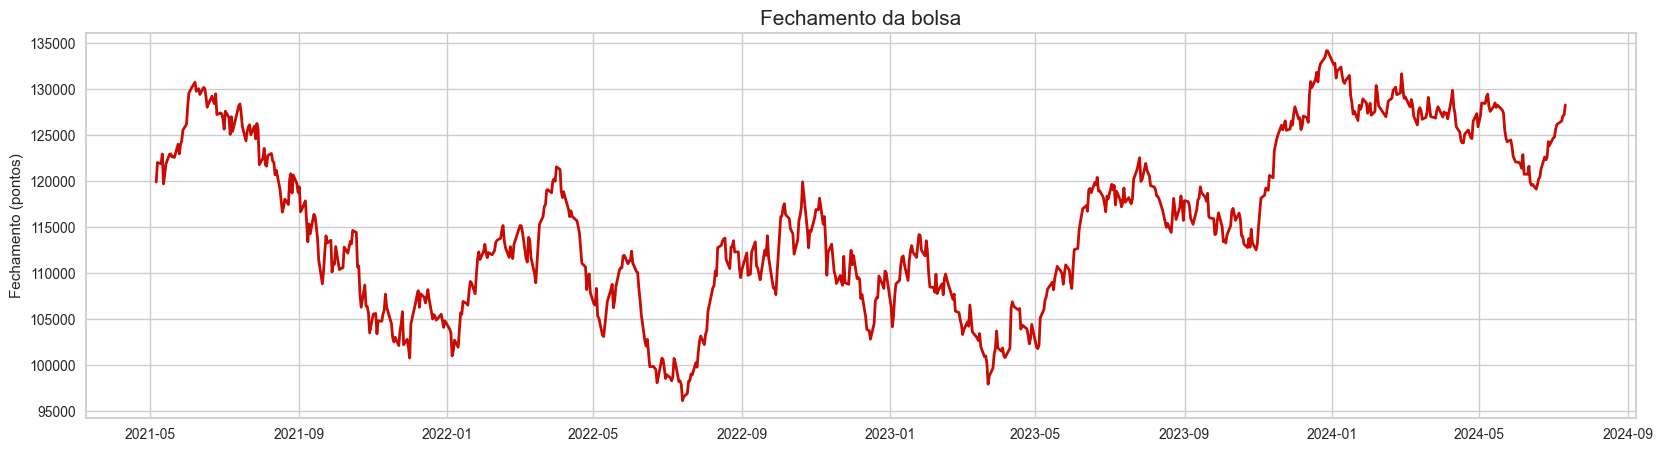

In [171]:
#Olhando a série de fechamento da bolsa
plt.figure(figsize=(20,5))
plt.plot(df_close['Close'], linewidth=2, color='r')
plt.title('Fechamento da bolsa',size=15)
plt.ylabel('Fechamento (pontos)')
plt.show()

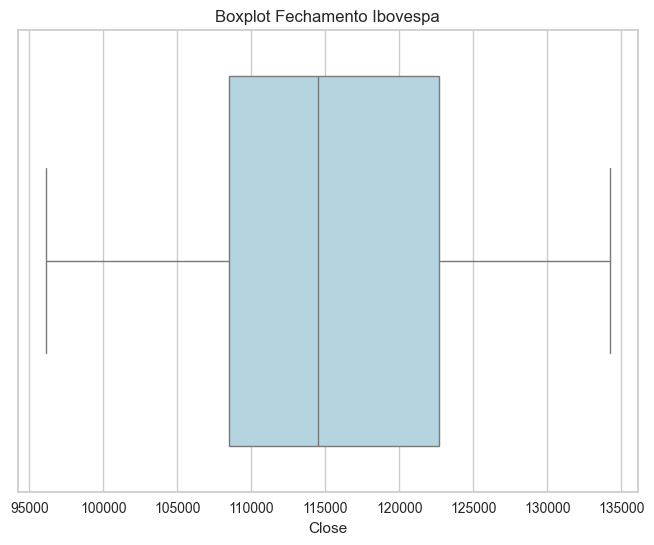

In [225]:
#Podemos também mesclar os dois tipos de gráficos para entender nossos valores discrepantes
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='Close', data=df_close, ax=ax, whis=1.5, color='#c6e5b1')
ax.set_title('Boxplot Fechamento Ibovespa')
#Mostrando o gráfico
plt.show()

In [ ]:
# Modelo de ANOVA
model = ols('Close ~ Volume + vix + selic + Dollar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq     df           F        PR(>F)
Volume    2.176969e+08    1.0    8.031472  4.714384e-03
vix       1.395336e+10    1.0  514.780058  3.798156e-88
selic     1.225467e+10    1.0  452.110632  1.098714e-79
Dollar    4.674315e+09    1.0  172.449086  8.960966e-36
Residual  2.141333e+10  790.0         NaN           NaN


In [ ]:
# Modelo de ANOVA
model = ols('Close ~ Volume + vix + selic + Dollar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq     df           F        PR(>F)
Volume    2.176969e+08    1.0    8.031472  4.714384e-03
vix       1.395336e+10    1.0  514.780058  3.798156e-88
selic     1.225467e+10    1.0  452.110632  1.098714e-79
Dollar    4.674315e+09    1.0  172.449086  8.960966e-36
Residual  2.141333e+10  790.0         NaN           NaN


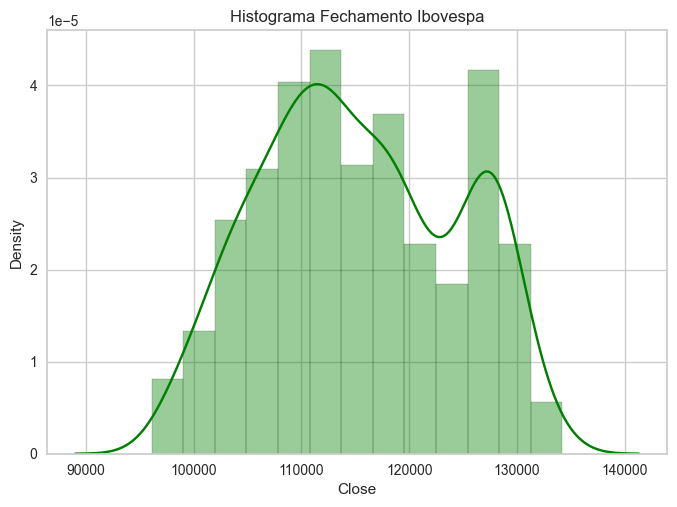

In [217]:

sns.distplot(a=df_close['Close'], color='green',
             hist_kws={"edgecolor": 'black'})
plt.title('Histograma Fechamento Ibovespa')
plt.show()

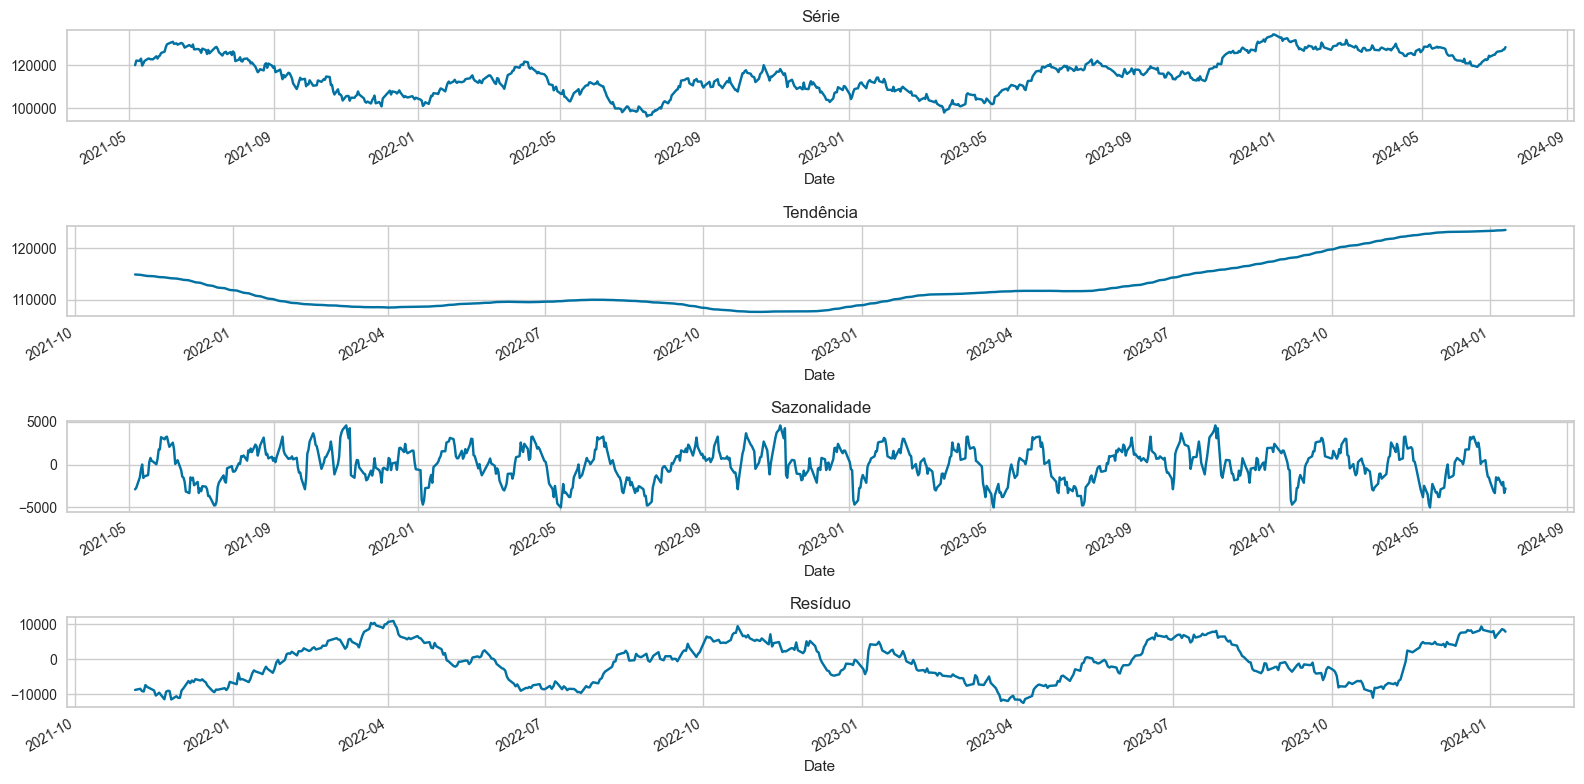

In [235]:
#Decomposição da série 
resultados = seasonal_decompose(df_close['Close'], period=252)

#Plotando
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(16,8))

resultados.observed.plot(ax=ax1, title = 'Série')

# Tendecia
resultados.trend.plot(ax=ax2, title = 'Tendência')
#Sazonalidade
resultados.seasonal.plot(ax=ax3, title = 'Sazonalidade')
#Residuo
resultados.resid.plot(ax=ax4, title = 'Resíduo')

plt.tight_layout()

In [197]:
##Teste Estatístico - Fuller
X = df_close.Close.values
results = adfuller(X)

print("Teste ADF")
print(f"Teste Estatistico: {results[0]}")
print(f"P-Value: {results[1]}")
print("Valores criticos:")

for key, value in results[4].items():
  print(f"{key}: {value}")

Teste ADF
Teste Estatistico: -1.8359663546802436
P-Value: 0.3627571818808134
Valores criticos:
1%: -3.4386126789104074
5%: -2.865186972298872
10%: -2.5687119871327146


In [236]:
#Teste de normalidade dos dados
import scipy

scipy.stats.shapiro(df_close.Close)


ShapiroResult(statistic=np.float64(0.971475324488854), pvalue=np.float64(2.407144207275644e-11))

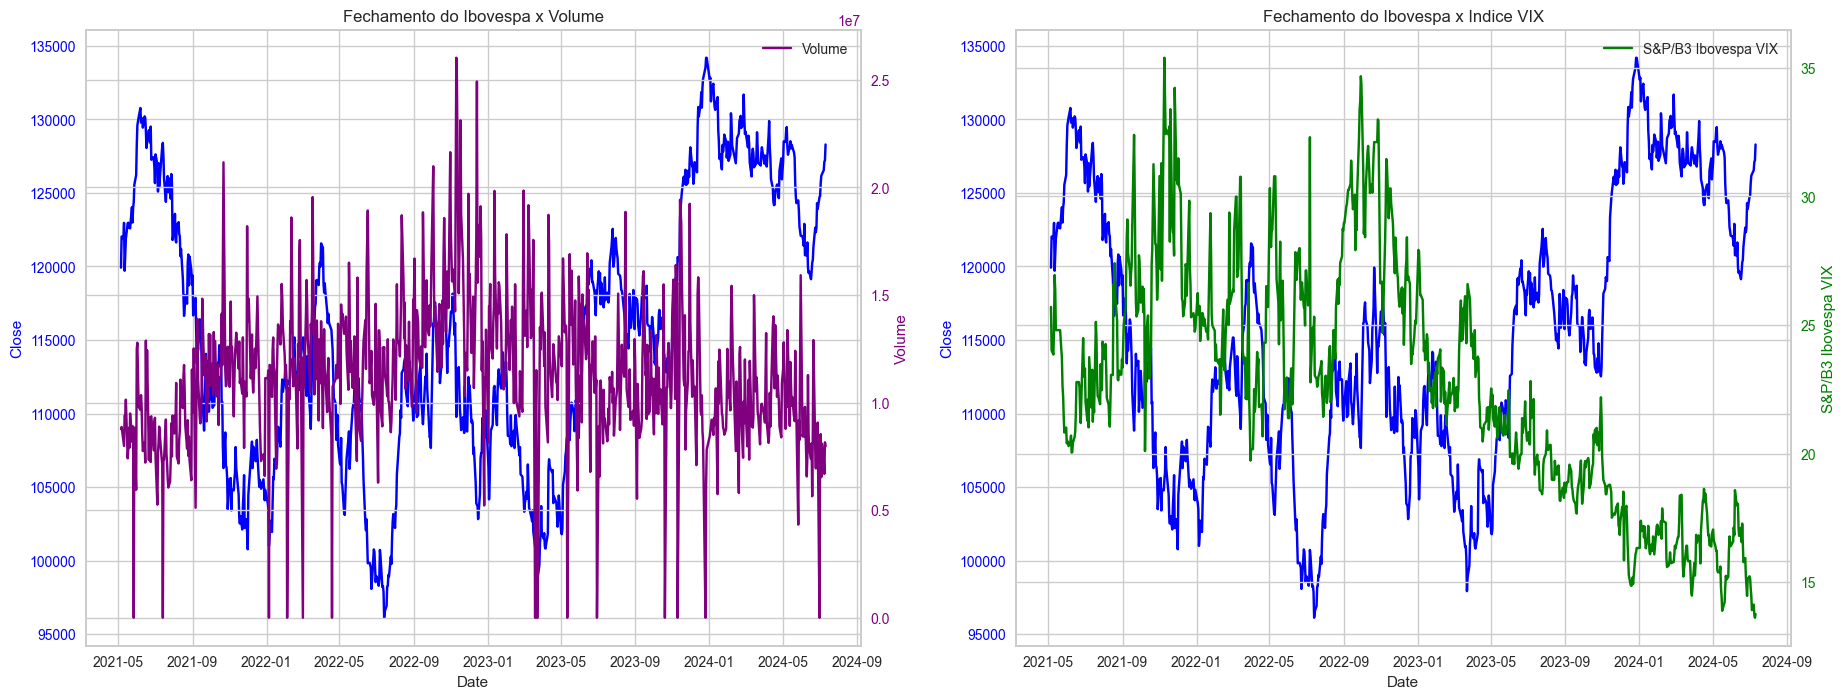

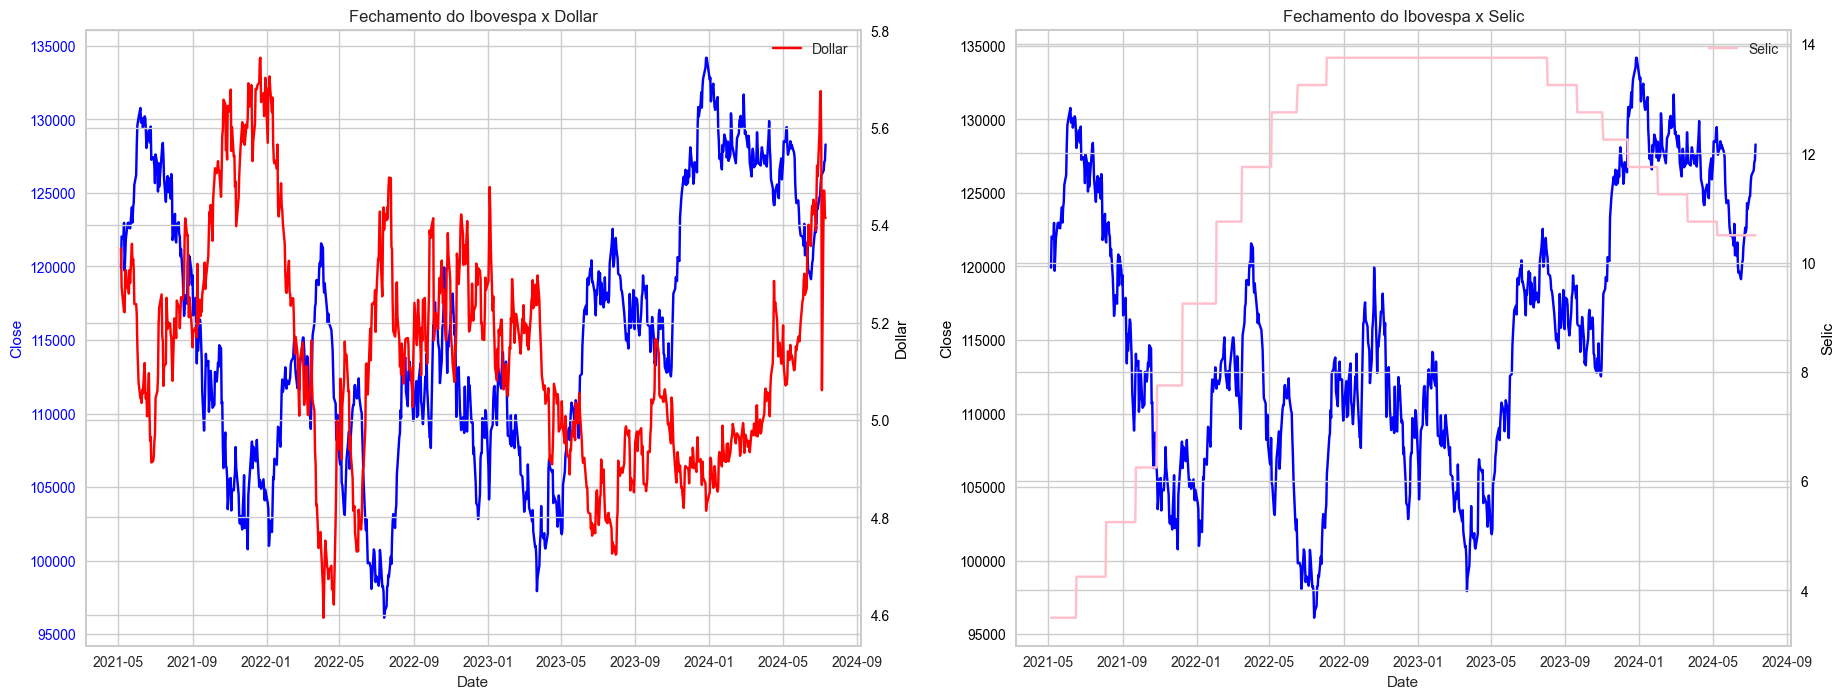

In [243]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (22, 8))
###Gráfico 3 Volume
ax1.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Volume
ax5 = ax1.twinx()
ax5.plot(df_close.index, df_close['Volume'], color='purple', label='Volume')
ax5.set_ylabel('Volume', color='purple')
ax5.tick_params(axis='y', labelcolor='purple')


###Gráfico 3 vix
ax2.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax2.set_xlabel('Date')
ax2.set_ylabel('Close', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.legend() 
plt.title('Fechamento do Ibovespa x Volume')

# VIX
ax5 = ax2.twinx()
ax5.plot(df_close.index, df_close['vix'], color='green', label='S&P/B3 Ibovespa VIX')
ax5.set_ylabel('S&P/B3 Ibovespa VIX', color='green')
ax5.tick_params(axis='y', labelcolor='green')
plt.legend() 
plt.title('Fechamento do Ibovespa x Indice VIX')

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize = (22, 8))
###Gráfico 3 Dolar
# Fechamento x dolar
ax3.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax3.set_xlabel('Date')
ax3.set_ylabel('Close', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')

# Dollar
ax5 = ax3.twinx()
ax5.plot(df_close.index, df_close['Dollar'], color='red', label='Dollar')
ax5.set_ylabel('Dollar', color='black')
ax5.tick_params(axis='y', labelcolor='black')
plt.legend() 
plt.title('Fechamento do Ibovespa x Dollar')

###Gráfico 4 Selic
ax4.plot(df_close.index, df_close['Close'], color='blue', label='Close Price')
ax4.set_xlabel('Date')
ax4.set_ylabel('Close', color='black')
ax4.tick_params(axis='y', labelcolor='black')

# Volume
ax5 = ax4.twinx()
ax5.plot(df_close.index, df_close['selic'], color='pink', label='Selic')
ax5.set_ylabel('Selic', color='black')
ax5.tick_params(axis='y', labelcolor='black')
plt.legend() 
plt.title('Fechamento do Ibovespa x Selic')

#fig.suptitle('Variáveis')
plt.show()

##### Análise de Correlação

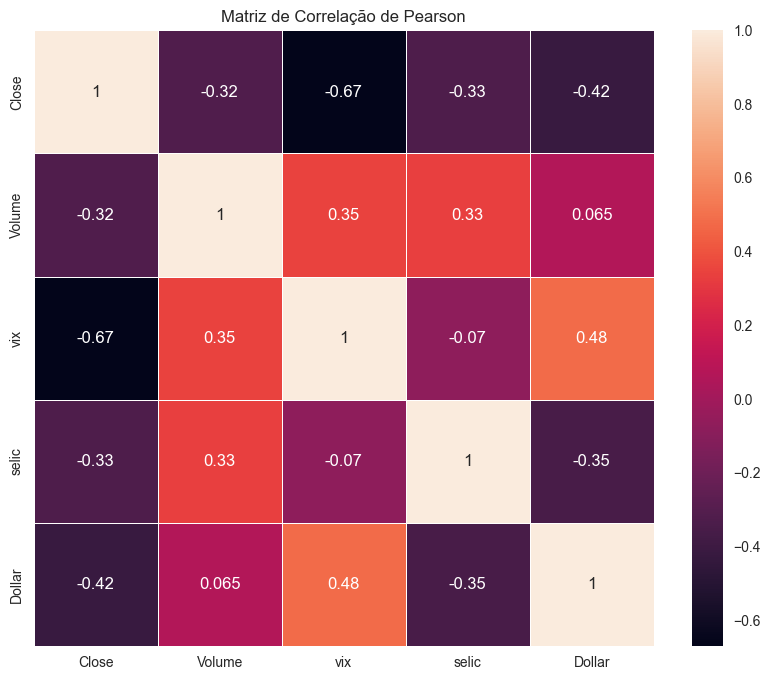

In [147]:
#Cria a matriz de correlação
correlation_matrix = df_close.corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)
plt.title('Matriz de Correlação de Pearson')
plt.show()

In [ ]:
# Modelo de ANOVA
model = ols('Close ~ Volume + vix + selic + Dollar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq     df           F        PR(>F)
Volume    2.176969e+08    1.0    8.031472  4.714384e-03
vix       1.395336e+10    1.0  514.780058  3.798156e-88
selic     1.225467e+10    1.0  452.110632  1.098714e-79
Dollar    4.674315e+09    1.0  172.449086  8.960966e-36
Residual  2.141333e+10  790.0         NaN           NaN


<Axes: title={'center': 'Correlação de Spearman'}>

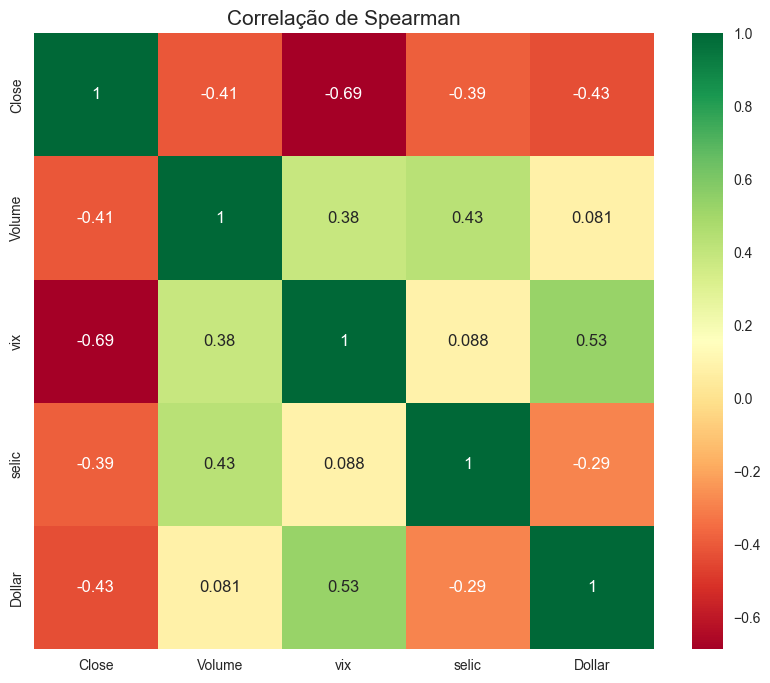

In [148]:
#Correlograma com a correlação de Spearman.
plt.figure(figsize=(10,8))
plt.title('Correlação de Spearman',size=15)
sns.heatmap(df_close.corr('spearman'), annot = True, cmap= "RdYlGn")

##### Estudo de outliers

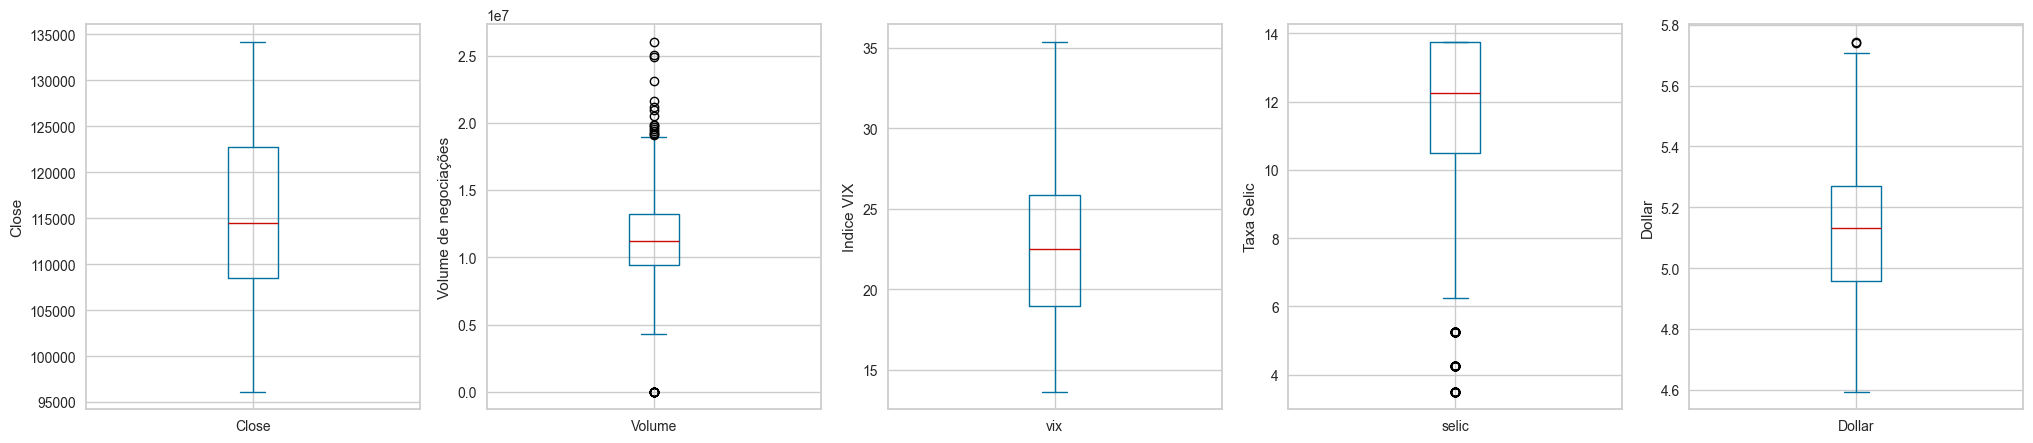

In [149]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (25, 5))

###Gráfico 1 Close
df_close['Close'].plot.box(ax = ax1)
ax1.set_ylabel('Close')

###Gráfico 2 - Volume
df_close['Volume'].plot.box(ax = ax2)
ax2.set_ylabel('Volume de negociações')

###Gráfico 3 - vix
df_close['vix'].plot.box(ax = ax3)
ax3.set_ylabel('Indice VIX')

###Gráfico 4 selic
df_close['selic'].plot.box(ax = ax4)
ax4.set_ylabel('Taxa Selic')

###Gráfico 5 Dollar
df_close['Dollar'].plot.box(ax = ax5)
ax5.set_ylabel('Dollar')


plt.show()

##### Distribuição

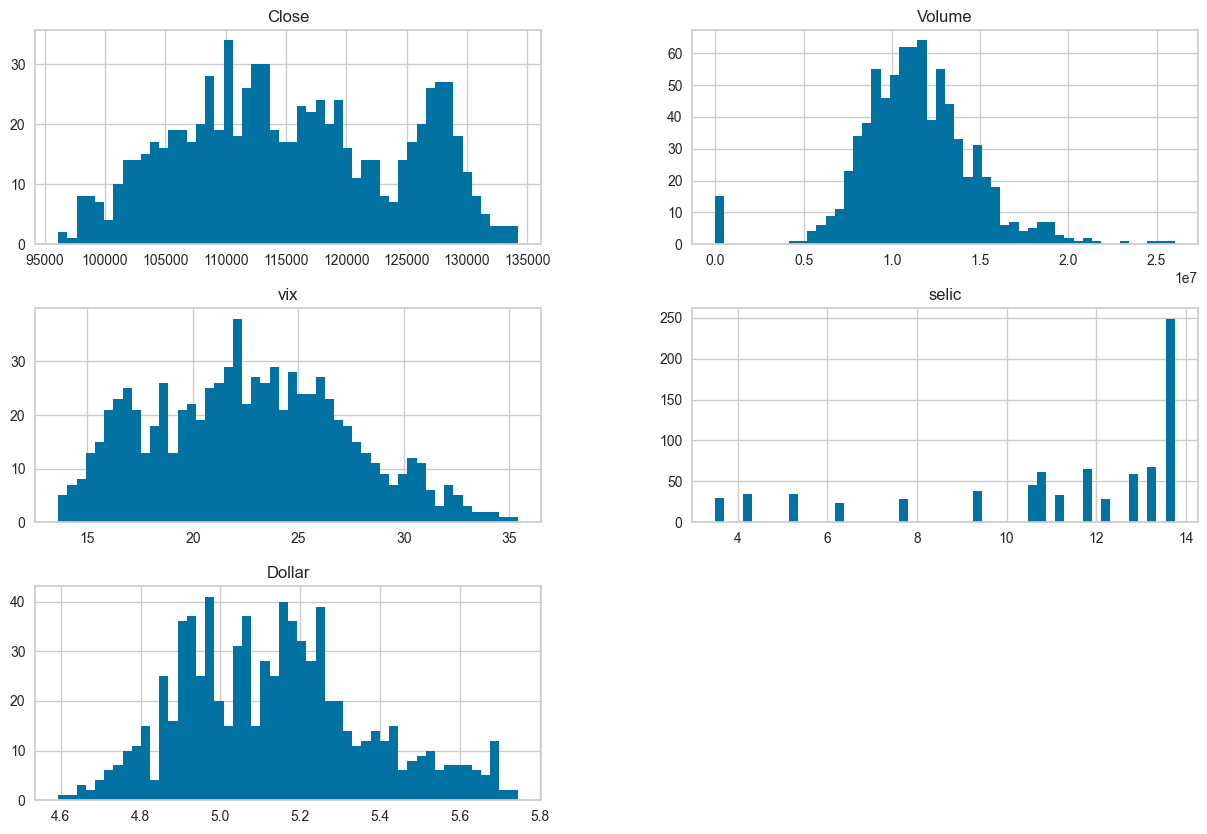

In [150]:
df_close[['Close', 'Volume',
       'vix', 'selic',
       'Dollar']].hist(figsize=(15,10), bins=50);

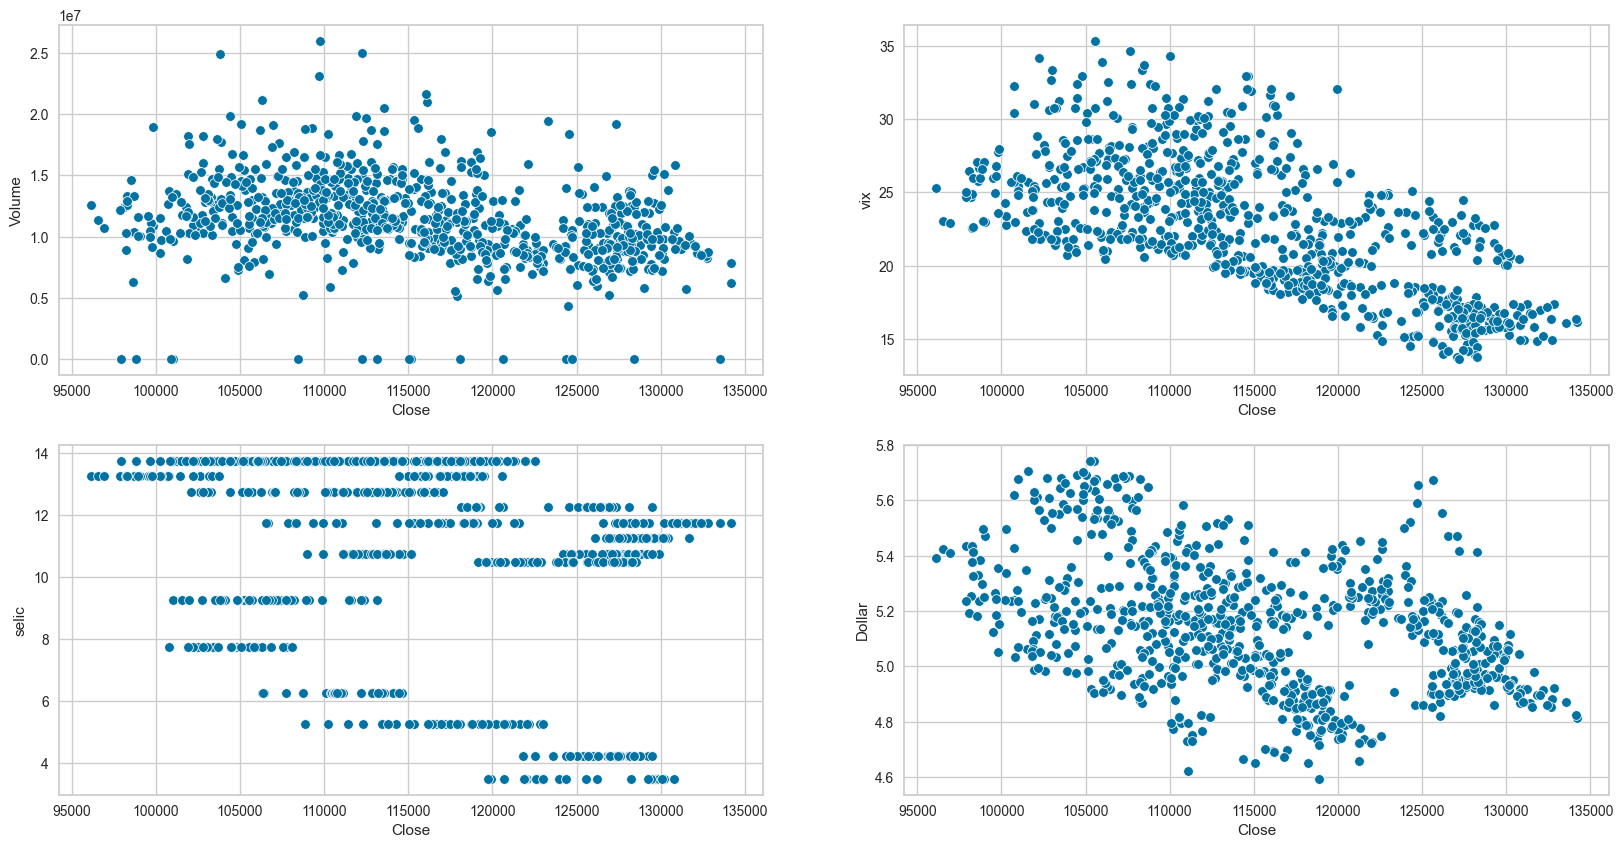

In [151]:
##Gráfico de dispersão entre as variáveis
fig,ax = plt.subplots(2,2, figsize=(20,10))
sns.scatterplot(x='Close',y='Volume',data = df_close,ax=ax[0][0]);
sns.scatterplot(x='Close',y='vix',data = df_close,ax=ax[0][1]);
sns.scatterplot(x='Close',y='selic',data = df_close,ax=ax[1][0]);
sns.scatterplot(x='Close',y='Dollar',data = df_close,ax=ax[1][1]);

##### Análise de Variância (ANOVA)

##### ANOVA: Avalia a significância estatística das variáveis independentes.

In [152]:
# Modelo de ANOVA
model = ols('Close ~ Volume + vix + selic + Dollar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq     df           F        PR(>F)
Volume    2.176969e+08    1.0    8.031472  4.714384e-03
vix       1.395336e+10    1.0  514.780058  3.798156e-88
selic     1.225467e+10    1.0  452.110632  1.098714e-79
Dollar    4.674315e+09    1.0  172.449086  8.960966e-36
Residual  2.141333e+10  790.0         NaN           NaN


##### Regressão linear múltipla: Quantifica a relação entre as variáveis independentes e a variável dependente

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import kurtosis
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt,het_white
from statsmodels.stats.diagnostic import linear_harvey_collier, linear_reset, spec_white
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from yellowbrick.regressor import CooksDistance
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from sklearn.linear_model import LinearRegression
import pingouin as pg

In [ ]:
X = df_close[['Volume', 'vix', 'selic', 'Dollar']] #Variáveis independentes
y = df_close['Close'] #Variável dependentes

In [154]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 23947817.697080467
R-squared: 0.6743490837890771


In [156]:
#transformando as variáveis para o formato numpy
Xp = X.to_numpy()
yp = y.to_numpy()

In [160]:
#Modelo de regressão com intercepto
lm1=pg.linear_regression(
X,y,add_intercept=True,relimp=True).round(4)
lm1

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,220265.3510,43.5602,5056.5760,0.0000,0.6657,0.664,220179.8436,220350.8584,NaN,NaN
1,Volume,0.0002,0.0001,2.8340,0.0047,0.6657,0.664,0.0001,0.0003,0.0419,6.2851
2,vix,-1109.3365,46.7995,-23.7040,0.0000,0.6657,0.664,-1201.2027,-1017.4704,0.3330,49.9372
3,selic,-1453.1604,60.8883,-23.8660,0.0000,0.6657,0.664,-1572.6823,-1333.6385,0.1554,23.3071
4,Dollar,-12786.8488,225.3910,-56.7318,0.0000,0.6657,0.664,-13229.2849,-12344.4126,0.1365,20.4706


In [161]:
lm1 = pg.linear_regression(X, y, add_intercept=True, relimp=True, as_dataframe=False)
print(lm1['df_model']) #graus de liberdade do modelo
print(lm1['df_resid']) #graus de liberdade dos resíduos

4
790


In [162]:
#Usando lm1['pred'] é possível acessar as previsões do modelo
x = lm1['pred'].tolist()
Y = y.tolist()

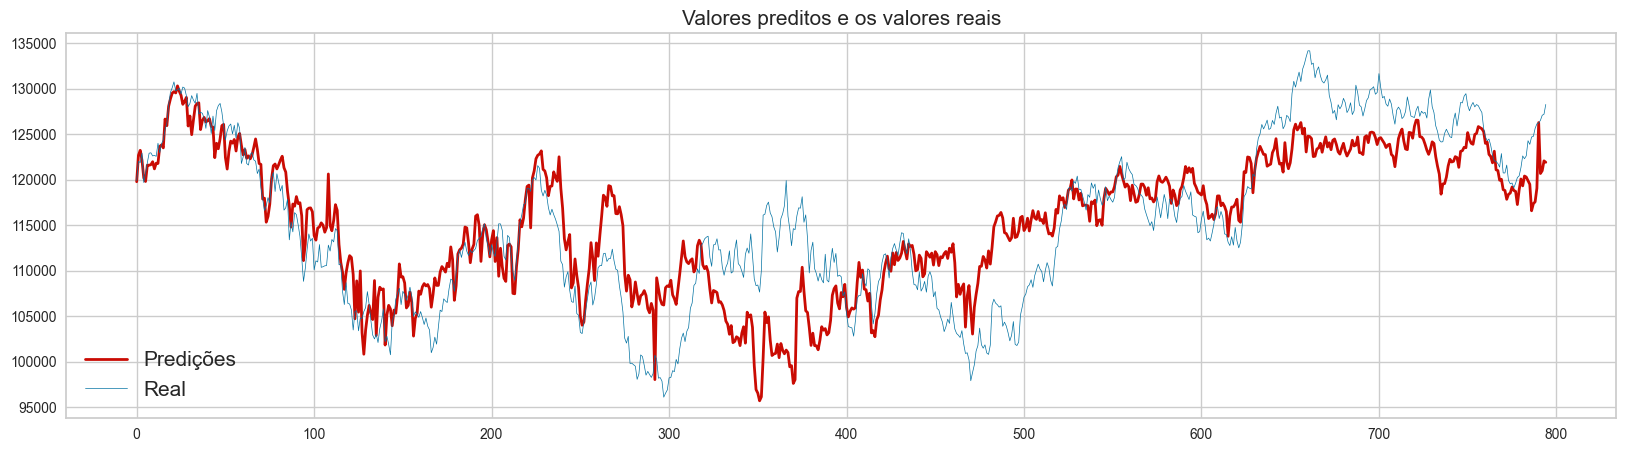

In [163]:
#valores reais com os valores preditos.
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(x, linewidth=2, color='r')
plt.plot(Y, linewidth=0.5,color='b')
plt.title('Valores preditos e os valores reais',size=15)
plt.legend(['Predições','Real'],fontsize=15)
plt.show()

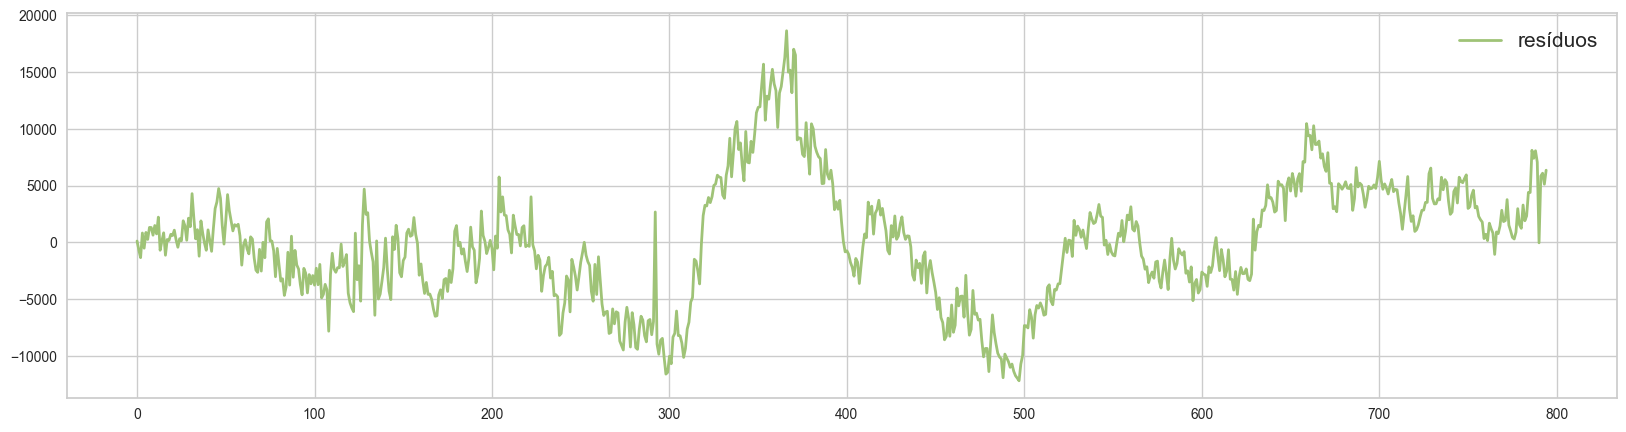

In [164]:
##Acessando os resíduos do modelo com intercepto.
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(lm1['residuals'].tolist(), linewidth=2, color='g')
plt.legend(['resíduos'],fontsize=15)
plt.show()

In [165]:
#Usando o Statsmodels
modelo1 = (sm.OLS(y,sm.add_constant(X)).fit())
modelo1.summary(title='Sumário do modelo com intercepto')

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Sumário do modelo com intercepto                        
================================================================================
Dep. Variable:                    Close   R-squared:                       0.666
Model:                              OLS   Adj. R-squared:                  0.664
Method:                   Least Squares   F-statistic:                     393.3
Date:              sábado, 20 jul. 2024   Prob (F-statistic):          2.74e-186
Time:                          22:59:03   Log-Likelihood:                -7928.9
No. Observations:                   795   AIC:                         1.587e+04
Df Residuals:                       790   BIC:                         1.589e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.203e+05   4893.000     45.016      0.000    2.11e+05     2.3e+05
Volume         0.0002   6.34e-05      2.834      0.005    5.52e-05       0.000
vix        -1109.3365     48.894    -22.689      0.000   -1205.313   -1013.360
selic      -1453.1604     68.343    -21.263      0.000   -1587.315   -1319.006
Dollar     -1.279e+04    973.718    -13.132      0.000   -1.47e+04   -1.09e+04
==============================================================================
Omnibus:                       18.940   Durbin-Watson:                   0.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.864
Skew:                           0.325   Prob(JB):                     2.95e-05
Kurtosis:                       3.454   Cond. No.                     3.21e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""